# Introducción

El ITAM y muchos de sus miembros tenemos residencia en la Ciudad de México. Esta metrópolis es una de las más contaminadas en el continente y en el mundo. A causa de la pandemia, una gran cantidad de la población pasamos mucho de nuestro tiempo encerrados en espacios cerrados, típicamente nuestras viviendas. Queremos saber cómo influyen los factores atmosféricos y la contaminación de la Ciudad en la contaminación de un espacio cerrado.

Hemos almacenado los datos de este sensor desde Febrero 2021 tratando de mantenerlos en un área común que no tiene ventilación directa para evitar perturbaciones en las lecturas y que sea influído directamente por la contaminación exterior, así como de otras fuentes de emisión (cocina). 

Es importante destacar que este sensor no detecta contaminantes primarios, tales como: óxidos de nitrógeno (NOx), dióxido de carbono (CO2), monóxido de carbono (CO), ozono (O3), más bien mide los compuestos orgánicos volátiles, conocidos por el acrónimo anglosajón VOCs. Los VOCs típicamente son muchos de los olores que percibimos, los cuales son disoluciones de compuestos en el aire.

Estos compuestos orgánicos volátiles se han comprobado como nocivos a la salud y posibles cancerígenos, lo cual nos despertó el interés. Ejemplos de estos compuestos orgánicos son: el humo del cigarro, humo causado por cocinar alimentos, la utilización de agentes de limpieza (cloro y basados en amoniaco) y fuentes volátiles varias (como solventes, pinturas, quitaesmaltes), entre otros.

## Fuentes de Datos Prospecto

Tenemos los siguientes de fuentes de datos:

* Sensor Bosch BME680: contamos aproximadamente con casi 1.3 millones de registros con lecturas del sensor cada 3 segundos.

* Datos Abiertos de la Calidad del Aire del Gobierno de la Ciudad de México: datos por hora de las estaciones de monitoreo del Gobierno. 

* Datos de otras estaciones meteorológicas de la Ciudad.

### Problemáticas

* Datos del Gobierno de la Ciudad de México: estos datos no están siendo actualizados de manera cotidiana, por lo que en ocasiones tienen atrasos en publicar la información actual. Ejemplo, al 31 de marzo no habían subido actualizaciones desde el 28 de enero. Pensamos contrarrestarlo utilizando la fuente de datos federal (Sinaica) que se encuentra en la bibliografía.

* Datos meteorológicos de terceros: Pudieran ser fuentes propietarias que serían de difícil acceso o hubiera que utilizar minería de datos (webscraping). Continuaremos buscando fuentes abiertas y confiables.

* Precisión y manipulación de los datos de nuestras fuentes de datos.

* Estabilidad y precisión de la toma de registros en el sensor. Pudiéramos tener interrupciones del suministro eléctrico que no permitieran obtener ciertas lecturas.

* Algoritmo cerrado del sensor para convertir de la variable `gasResistance` a la variable `IAQ`; el cual es cerrado. Sólo proporcionan un objeto binario, que se puede ejecutar en Linux, Windows, ARM y ligándolo en C, el cual procesa la variable `gasResistance`. [1] [2]

    * Al parecer esta variable se genera como una serie de tiempo y llega a guardar hasta 24 hrs de estados previos de ejecución del sensor. [3]
    
    * Este código es protegido como propiedad intelectual del fabricante del sensor (Bosch), lo cual impide que se pueda hacer desensamble o ingeniería inversa.
    
    * Se pudiera utilizar el objeto binario en un ejecutable en Linux o Windows, donde pudiese ser convertida no desde el sensor, sino desde nuestras predicciones de la variable gasResistance; y con este código binario más nuestro ejecutable que ligue ambos convierta los valores de gasResistance.
    
    * Alternativamente se puede generar una red neuronal que convierta la variable `gasResistance` (como variable explicativa, incluso agregar las otras) y convertirlas a IAQ (variable respuesta).

## Variables 

Las siguientes son las variables obtenidas por el sensor Bosch BME680:

* Temperatura: variable numérica en grados Celsius (C) con una resolución de $0.01C$ y una precisión de $\pm 0.5C$.

* Presión: variable numérica en hectopascales (hPa) con una resolución de $0.18~hPa$ y una precisión de $\pm 0.12~hPA$.

* Humedad: variable numérica en porcentaje de humedad relativa (%rH) con una resolución de $0.008~\%rH$ y una precisión de $\pm 3\%rH$.

* Resistencia del Gas: variable numérica de la resistencia eléctrica opuesta al elemento sensible del sensor medida en Ohms.

* IAQ: variable numérica medida en el índice de calidad del aire americano en interior (IAQI, aunque utilizaremos la nomenclatura IAQ) con una resolución de $1~ IAQ$. La precisión del sensor variable que no excede 5% se guarda en una variable independiente. 

* Precisión del sensor: variable categórica ordinal con valores en el rango de [0,3]:

    * 0: periodo de estabilización o no operativo.
    
    * 1-2: periodo operativo.
    
    * 3: precisión máxima y operación óptima.

* Fecha y hora: variable numérica basado en UNIX/POSIX epoch que denota el tiempo desde el 01/01/1970 00:00:00.0 UTC. El tiempo está sincronizado por NTP al Centro Nacional de Metrología de México (Hora Oficial del País). 

## Análisis Exploratorio Inicial

Hemos empezado a realizar un análisis exploratorio de los datos y recopilación de los datos de fuentes externas. A continuación mostramos algunas gráficas de las lecturas del sensor.

In [ ]:
%matplotlib inline
import os, gzip, json
from plotnine import *
import pandas as pd
from IPython.display import display, Markdown, Image, clear_output

df = pd.read_pickle("airdata/air.pickle")
display(Markdown(f"* Rango de fechas obtenidas: {df.datetime.min()} - {df.datetime.max()}"))
display(Markdown(f"* Número de registros: {df.shape[0]:3,}"))
display(Markdown(f"* Promedio de IAQ: {df.IAQ.mean():.2f} desviación estándar: {df.IAQ.std():.2f}"))

* Rango de fechas obtenidas: 2021-02-12 06:04:09.089621067 - 2021-03-28 10:23:00.196267605

* Número de registros: 1,274,818

* Promedio de IAQ: 159.75 desviación estándar: 73.65

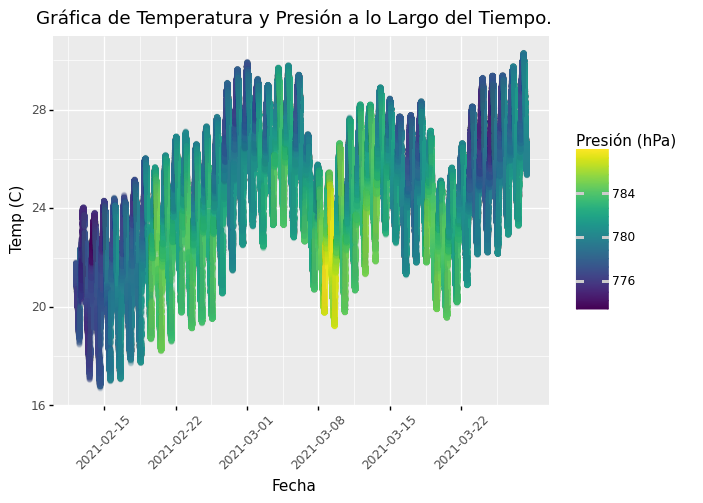

In [ ]:
_ = (
    ggplot(df, aes(x = "datetime", y = "temperature", color="pressure")) +
    geom_jitter(alpha=0.05) +
    theme(axis_text_x=element_text(angle=45)) +
    labs(x="Fecha", y="Temp (C)", color="Presión (hPa)", 
         title="Gráfica de Temperatura y Presión a lo Largo del Tiempo.") 
).draw()

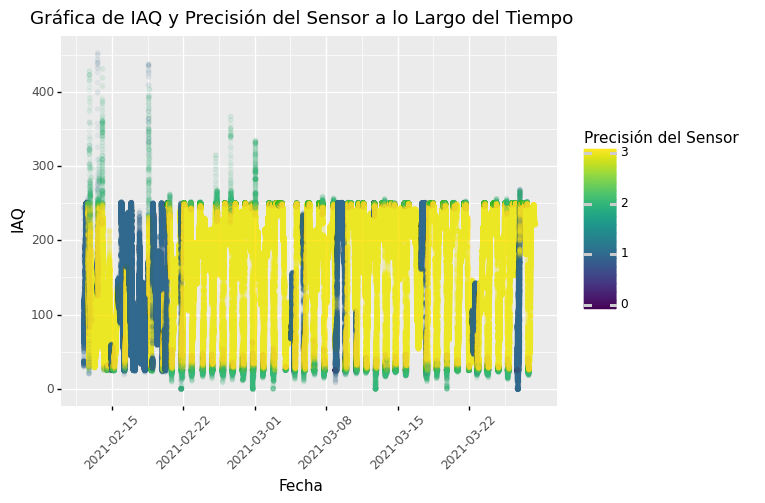

In [ ]:
_ = (
    ggplot(df, aes(x = "datetime", y = "IAQ", color="iaqAccuracy")) +
    geom_jitter(alpha=0.05, size=1.25) +
    theme(axis_text_x=element_text(angle=45)) +
    labs(x="Fecha", color="Precisión del Sensor",
         title="Gráfica de IAQ y Precisión del Sensor a lo Largo del Tiempo")
).draw()

## Modelo

Proponemos utilizar un modelo de aprendizaje profundo con distintos tipos de neuronas artificiales:

* RNN: red neuronal recurrente.

* CNN: red neuronal convolucional.

* DNN: red neuronal densa.

Además de utilizar técnicas de series de tiempo, estadística frecuentista y bayesiana para el análisis de los datos.

# Trabajos relacionados

Hemos realizado algunos trabajos previos (1) y buscado artículos relacionados que describimos a continuación:

1. Examen final para la materia de "Modelos de Gran Escala" con la Prof. Liliana Millán, donde se estudiaron la relación de las estaciones de biciletas "Ecobici" con la calidad del aire en las inmediaciones.

2. Development of indoor environmental index: Air quality index and thermal comfort index. Referido en la bibliografía.


# Solución

Expondremos la relación que existe, si es que la hay, entre la calidad del aire exterior y la de una casa habitación. Así como el poder predictivo con métricas de su precisión ("accuracy"). En cuyo caso podríamos dar pie a que esta investigación termine en un Producto de Datos.

# Conclusiones

Buscaremos explicar nuestras conclusiones del análisis de:

* Análisis  exploratorios sobre los datos.

* Nuestras hipótesis y sus resultados.

* Nuestras pruebas con modelos de redes neuronales profundas y el procesamiento de señales.

* Los inconvenientes que encontramos y la influencia que ejercieron sobre el presente proyecto.

* Aprendizajes obtenidos durante el presente.

# Bibliografía

* [1] [Bosch Sensortec Community | How do I convert BME 680 gas resistance to IAQ?](https://community.bosch-sensortec.com/t5/Question-and-answers/How-do-I-convert-BME680-gas-resistance-to-IAQ/qaq-p/9050/comment-id/94#M94).

* [2] [Bosch SensorTec Comunity | Solution to IAQ accuracy definition](https://community.bosch-sensortec.com/t5/MEMS-sensors-forum/BME680-IAQ-accuracy-definition/m-p/5931/highlight/true#M10).

* [3] [GitHub | Daniel Mancuso: Código fuente de OhmTech-io/uThingVOC Src/main.c](https://github.com/ohmtech-io/uThingVOC/blob/f345fdbef6a4fd0da77289b436e3c478706572a2/Src/main.c#L139)

* [Bosch BME680 Datasheet](https://www.bosch-sensortec.com/media/boschsensortec/downloads/datasheets/bst-bme680-ds001.pdf). 2021.

* Mancuso, D. [Indoor Air Quality Monitor | Hackster.io](https://www.hackster.io/damancuso/indoor-air-quality-monitor-b181e9). 2019.

* [Dirección de Monitoreo Atmosféerico de la Secretaría del Medio Ambiente del Gobierno de la Ciudad de México](http://www.aire.cdmx.gob.mx/).

* [Sistema Nacional de Información de la Calidad del Aire del Gobierno Federal México](https://sinaica.inecc.gob.mx/).

*  Saadi S. M., et al. Development of indoor environmental index: Air quality index and thermal comfort index. 2017. [doi:10.1063/1.4975276](https://doi.org/10.1063/1.4975276).

* Pedregosa, Fabian; et al. [Scikit-learn: Machine Learning in Python](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 2021.

* Abadi, Martín, et al. [TensorFlow: Large-scale machine learning on heterogeneous systems](https://tensorflow.org). 2015. 

* McKinney, Wes. [Data structures for statistical computing in python](https://conference.scipy.org/proceedings/scipy2010/pdfs/mckinney.pdf). 2010.

* Harris, Charles, et al. Array programming with NumPy. 2021. [doi:10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2).

* Hunter, John. Matplotlib: A 2D Graphics Environment. 2007. [doi:10.5281/zenodo.592536/zenodo.592536](https://doi.org/10.5281/zenodo.592536https://doi.org/10.5281/zenodo.592536).